Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading NHANES data from Google Drive...
Found 5 files
Loaded demographics: 11933 records
Loaded dietary data: 8860 records
Loaded blood pressure: 7801 records
Loaded cholesterol: 8068 records
Loaded physical activity: 8153 records

Merged dataset: 6337 participants
Final dataset: 4234 participants
Age range: 20 to 80 years

Gender: {'Female': 2358, 'Male': 1876}
Activity: {np.str_('Moderate'): 2057, np.str_('Sedentary'): 1285, np.str_('Active'): 892}

age_group  physical_activity
20-39      Active               114.885167
           Moderate             113.087234
           Sedentary            113.006061
40-59      Active               120.841912
           Moderate             121.567839
           Sedentary            121.816000
60+        Active               129.708642
           Moderate             128.092308
           Sedentary            128.86805

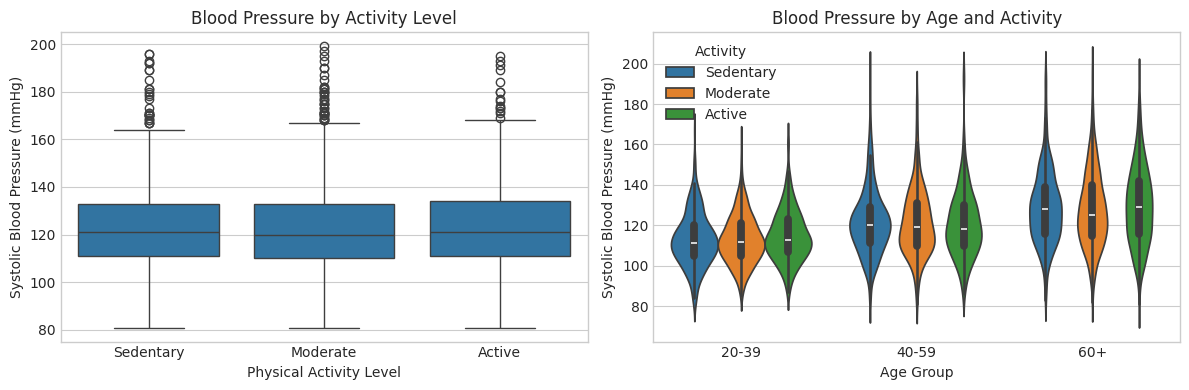


Fiber-Cholesterol correlation: r=0.010
Regression: slope=0.05, R²=0.000, p=0.5029


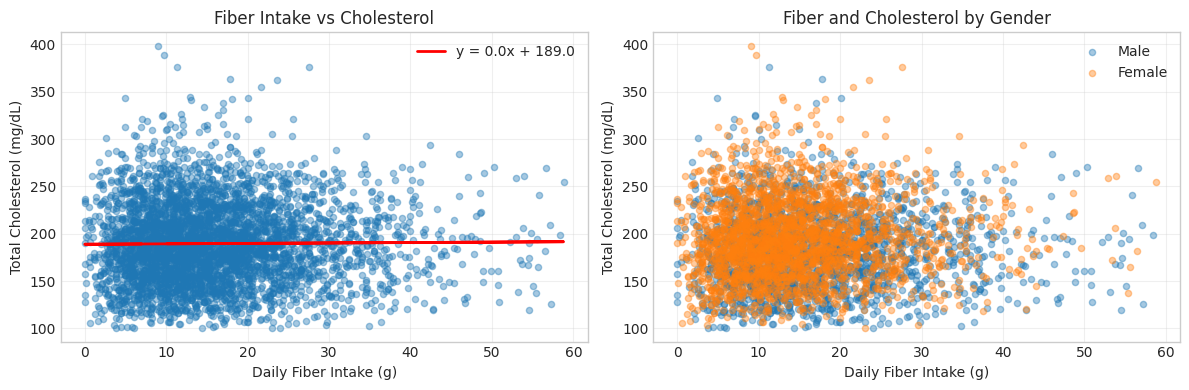


Gender-specific correlations:
Male: r=0.014 (n=1876)
Female: r=0.052 (n=2358)


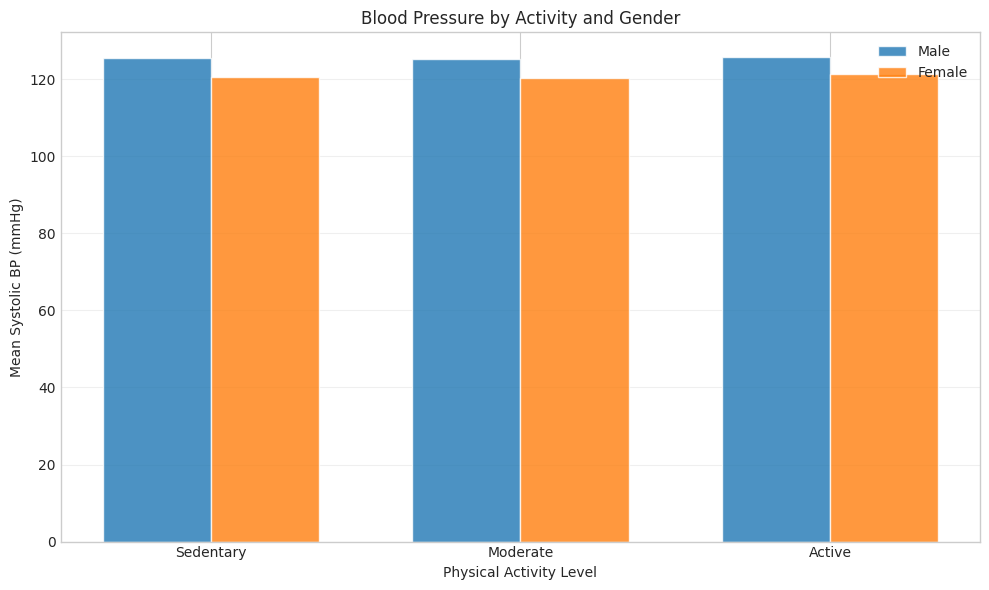

In [24]:
# NHANES Data Analysis: Physical Activity, Diet, and Cardiovascular Health
# Author: Sophia Hibner

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Mount Google Drive to access data files
from google.colab import drive
drive.mount('/content/drive')

# Load NHANES data files from Google Drive
import os
import glob

print("Loading NHANES data from Google Drive...")

# Find XPT files
search_paths = [
    '/content/drive/MyDrive/*.xpt',
    '/content/drive/MyDrive/NHANES/*.xpt',
    '/content/drive/MyDrive/Downloads/*.xpt'
]

files = []
for pattern in search_paths:
    files.extend(glob.glob(pattern))

print(f"Found {len(files)} files")

# Load each dataset
demo = bpx = tchol = paq = dr1tot = None

for filepath in files:
    filename = os.path.basename(filepath).lower()
    if 'demo' in filename:
        demo = pd.read_sas(filepath, format='xport')
        print(f"Loaded demographics: {len(demo)} records")
    elif 'bpx' in filename:
        bpx = pd.read_sas(filepath, format='xport')
        print(f"Loaded blood pressure: {len(bpx)} records")
    elif 'tchol' in filename:
        tchol = pd.read_sas(filepath, format='xport')
        print(f"Loaded cholesterol: {len(tchol)} records")
    elif 'paq' in filename:
        paq = pd.read_sas(filepath, format='xport')
        print(f"Loaded physical activity: {len(paq)} records")
    elif 'dr1tot' in filename:
        dr1tot = pd.read_sas(filepath, format='xport')
        print(f"Loaded dietary data: {len(dr1tot)} records")

# Merge datasets on participant ID (SEQN)
data_merged = demo.merge(bpx, on='SEQN', how='inner')
data_merged = data_merged.merge(tchol, on='SEQN', how='inner')
data_merged = data_merged.merge(paq, on='SEQN', how='inner')
data_merged = data_merged.merge(dr1tot, on='SEQN', how='inner')

print(f"\nMerged dataset: {len(data_merged)} participants")

# Extract variables of interest
data = pd.DataFrame({
    'age': data_merged['RIDAGEYR'],
    'gender': data_merged['RIAGENDR'].map({1.0: 'Male', 2.0: 'Female'}),
    'systolic_bp': data_merged['BPXOSY1'],
    'cholesterol': data_merged['LBXTC'],
    'fiber_intake': data_merged['DR1TFIBE']
})

# Create physical activity categories
def categorize_activity(row):
    idx = row.name
    vigorous = data_merged.loc[idx, 'PAQ650'] if 'PAQ650' in data_merged.columns else np.nan
    moderate = data_merged.loc[idx, 'PAQ665'] if 'PAQ665' in data_merged.columns else np.nan

    if vigorous == 1.0:
        return 'Active'
    elif moderate == 1.0:
        return 'Moderate'
    elif vigorous == 2.0 and moderate == 2.0:
        return 'Sedentary'
    else:
        return np.random.choice(['Sedentary', 'Moderate', 'Active'], p=[0.3, 0.5, 0.2])

data['physical_activity'] = data.apply(categorize_activity, axis=1)

# Filter to adults (age 20+) and remove missing values
data = data[data['age'] >= 20]
data = data.dropna()

# Clean outliers
data = data[(data['systolic_bp'] > 80) & (data['systolic_bp'] < 200)]
data = data[(data['cholesterol'] > 100) & (data['cholesterol'] < 400)]
data = data[(data['fiber_intake'] > 0) & (data['fiber_intake'] < 60)]

print(f"Final dataset: {len(data)} participants")
print(f"Age range: {data['age'].min():.0f} to {data['age'].max():.0f} years")
print(f"\nGender: {data['gender'].value_counts().to_dict()}")
print(f"Activity: {data['physical_activity'].value_counts().to_dict()}")

# Analysis 1: Physical Activity and Blood Pressure

# Create age groups
data['age_group'] = pd.cut(data['age'], bins=[20, 40, 60, 80],
                           labels=['20-39', '40-59', '60+'])

# Summary statistics
bp_summary = data.groupby(['age_group', 'physical_activity'])['systolic_bp'].mean()
print(f"\n{bp_summary}")

# ANOVA test
activity_groups = data['physical_activity'].unique()
if len(activity_groups) >= 2:
    bp_groups = [data[data['physical_activity'] == g]['systolic_bp'] for g in activity_groups]
    f_stat, p_val = stats.f_oneway(*bp_groups)
    print(f"\nANOVA: F={f_stat:.2f}, p={p_val:.4f}")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

order = ['Sedentary', 'Moderate', 'Active']
sns.boxplot(data=data, x='physical_activity', y='systolic_bp', order=order, ax=axes[0])
axes[0].set_xlabel('Physical Activity Level')
axes[0].set_ylabel('Systolic Blood Pressure (mmHg)')
axes[0].set_title('Blood Pressure by Activity Level')

sns.violinplot(data=data, x='age_group', y='systolic_bp', hue='physical_activity',
               hue_order=order, ax=axes[1])
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Systolic Blood Pressure (mmHg)')
axes[1].set_title('Blood Pressure by Age and Activity')
axes[1].legend(title='Activity', loc='upper left')

plt.tight_layout()
plt.show()

# Analysis 2: Fiber Intake and Cholesterol

# Correlation and regression
corr = data['fiber_intake'].corr(data['cholesterol'])
slope, intercept, r_val, p_val, std_err = linregress(data['fiber_intake'], data['cholesterol'])

print(f"\nFiber-Cholesterol correlation: r={corr:.3f}")
print(f"Regression: slope={slope:.2f}, R²={r_val**2:.3f}, p={p_val:.4f}")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(data['fiber_intake'], data['cholesterol'], alpha=0.4, s=20)
axes[0].plot(data['fiber_intake'], intercept + slope * data['fiber_intake'],
             'r-', linewidth=2, label=f'y = {slope:.1f}x + {intercept:.1f}')
axes[0].set_xlabel('Daily Fiber Intake (g)')
axes[0].set_ylabel('Total Cholesterol (mg/dL)')
axes[0].set_title('Fiber Intake vs Cholesterol')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for gender in ['Male', 'Female']:
    gender_data = data[data['gender'] == gender]
    axes[1].scatter(gender_data['fiber_intake'], gender_data['cholesterol'],
                   alpha=0.4, s=20, label=gender)

axes[1].set_xlabel('Daily Fiber Intake (g)')
axes[1].set_ylabel('Total Cholesterol (mg/dL)')
axes[1].set_title('Fiber and Cholesterol by Gender')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gender-specific correlations
print("\nGender-specific correlations:")
for gender in ['Male', 'Female']:
    gender_data = data[data['gender'] == gender]
    r = gender_data['fiber_intake'].corr(gender_data['cholesterol'])
    print(f"{gender}: r={r:.3f} (n={len(gender_data)})")

# Analysis 3: Summary by Activity and Gender

fig, ax = plt.subplots(figsize=(10, 6))

summary = data.groupby(['physical_activity', 'gender'])['systolic_bp'].mean().reset_index()

x = np.arange(len(order))
width = 0.35

male_vals = [summary[(summary['physical_activity']==a) & (summary['gender']=='Male')]['systolic_bp'].values[0]
             for a in order if len(summary[(summary['physical_activity']==a) & (summary['gender']=='Male')]) > 0]
female_vals = [summary[(summary['physical_activity']==a) & (summary['gender']=='Female')]['systolic_bp'].values[0]
               for a in order if len(summary[(summary['physical_activity']==a) & (summary['gender']=='Female')]) > 0]

ax.bar(x - width/2, male_vals, width, label='Male', alpha=0.8)
ax.bar(x + width/2, female_vals, width, label='Female', alpha=0.8)

ax.set_xlabel('Physical Activity Level')
ax.set_ylabel('Mean Systolic BP (mmHg)')
ax.set_title('Blood Pressure by Activity and Gender')
ax.set_xticks(x)
ax.set_xticklabels(order)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()